# GoingDeeper - CutMix or Mixup

## 프로젝트: CutMix 또는 Mixup 비교실험 하기

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### GPU 환경 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


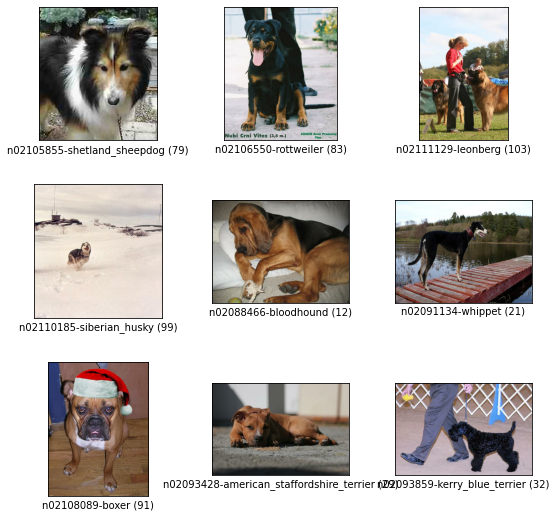

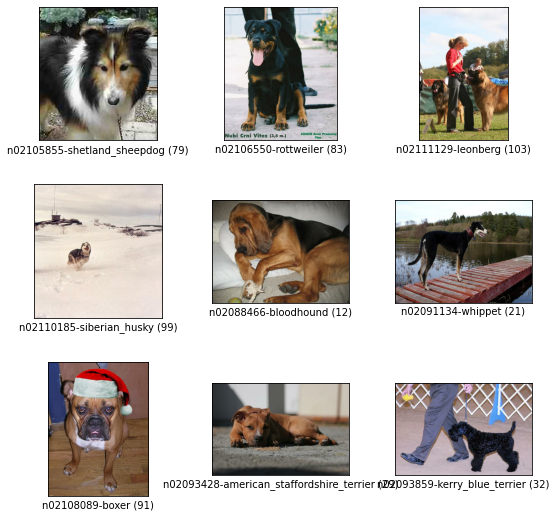

In [4]:
tfds.show_examples(ds_train, ds_info)

## Augmentation을 적용한 데이터셋 만들기

### 정규화 및 이미지 크기 변경 함수

In [5]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])          
    image = tf.cast(image, tf.float32) / 255.           # 0~1 사이의 float32로 정규화
    return image, label

### 원-핫 인코딩

In [6]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### 좌우 대칭, 밝기 변경

In [7]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)            
    image = tf.image.random_brightness(image, max_delta=0.2)   
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## CutMix

### 삽입될 영역 바운딩 박스 위치 결정 함수

In [8]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

### CutMix - 이미지 섞기

In [9]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

### 라벨 섞기

In [10]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

### 배치 단위의 cutmix 함수

In [11]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### Mixup

In [12]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

### 배치 단위의 mixup 함수

In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 데이터셋에 augmentation 적용

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    
    # 기본 augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # cutmix augmentation
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup augmentation    
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

### Augmentation 적용, 비교실험

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

### Class

In [16]:
num_classes = ds_info.features["label"].num_classes

### Augmentation 적용 

In [17]:
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)

### Augmentation 적용  X

In [18]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)

### 정의

In [19]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

### CutMix Augmentation 적용 데이터셋

In [20]:
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)

### Mixup Augmentation 적용 데이터셋

In [21]:
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

### Test 데이터셋

In [22]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 모델 만들기

## ResNet-50

### Augmentation 적용하지 않은 ResNet

In [23]:
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


### Augmentation 적용 ResNet

In [24]:
resnet50_base_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### CutMix Augmentation 적용 ResNet

In [25]:
resnet50_cutmix_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### Mixup Augmentation 적용 ResNet

In [26]:
resnet50_mixup_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,    
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 모델 훈련하기 >> categorical_crossentropy 사용

In [27]:
BATCH_SIZE = 16
EPOCH = 10

## Augmentation 적용 X 

In [30]:
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [31]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 156s 200ms/step - loss: 2.2433 - accuracy: 0.4417 - val_loss: 3.3842 - val_accuracy: 0.2193
Epoch 2/10
750/750 [==============================] - 149s 199ms/step - loss: 0.7237 - accuracy: 0.8012 - val_loss: 1.2124 - val_accuracy: 0.6490
Epoch 3/10
750/750 [==============================] - 149s 199ms/step - loss: 0.2140 - accuracy: 0.9578 - val_loss: 1.1066 - val_accuracy: 0.6827
Epoch 4/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0630 - accuracy: 0.9952 - val_loss: 0.9110 - val_accuracy: 0.7372
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0292 - accuracy: 0.9985 - val_loss: 0.9677 - val_accuracy: 0.7270
Epoch 6/10
750/750 [==============================] - 149s 198ms/step - loss: 0.0168 - accuracy: 0.9997 - val_loss: 0.9339 - val_accuracy: 0.7443
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0121 - accuracy: 0.9997 - val_loss: 0.9807 -

## 기본 Augmentation 적용

In [32]:
resnet50_base_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [33]:
history_resnet50_base_aug = resnet50_base_aug.fit(
    ds_train_base_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 156s 200ms/step - loss: 2.2596 - accuracy: 0.4309 - val_loss: 2.8942 - val_accuracy: 0.2792
Epoch 2/10
750/750 [==============================] - 149s 198ms/step - loss: 0.9313 - accuracy: 0.7362 - val_loss: 1.4682 - val_accuracy: 0.5914
Epoch 3/10
750/750 [==============================] - 165s 219ms/step - loss: 0.4966 - accuracy: 0.8671 - val_loss: 1.0157 - val_accuracy: 0.7022
Epoch 4/10
750/750 [==============================] - 149s 199ms/step - loss: 0.2559 - accuracy: 0.9377 - val_loss: 1.1790 - val_accuracy: 0.6677
Epoch 5/10
750/750 [==============================] - 149s 199ms/step - loss: 0.1503 - accuracy: 0.9699 - val_loss: 1.0042 - val_accuracy: 0.7155
Epoch 6/10
750/750 [==============================] - 149s 198ms/step - loss: 0.0788 - accuracy: 0.9894 - val_loss: 1.0568 - val_accuracy: 0.7035
Epoch 7/10
750/750 [==============================] - 149s 199ms/step - loss: 0.0495 - accuracy: 0.9941 - val_loss: 0.9498 -

## CutMix Augmentation

In [28]:
resnet50_cutmix_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [29]:
history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(
    ds_train_cutmix_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 200s 219ms/step - loss: 3.8055 - accuracy: 0.2189 - val_loss: 3.5060 - val_accuracy: 0.1848
Epoch 2/10
750/750 [==============================] - 150s 201ms/step - loss: 2.9461 - accuracy: 0.4351 - val_loss: 1.4256 - val_accuracy: 0.6156
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 2.6611 - accuracy: 0.5252 - val_loss: 1.2476 - val_accuracy: 0.6489
Epoch 4/10
750/750 [==============================] - 150s 200ms/step - loss: 2.4244 - accuracy: 0.5993 - val_loss: 1.1041 - val_accuracy: 0.6880
Epoch 5/10
750/750 [==============================] - 150s 200ms/step - loss: 2.2588 - accuracy: 0.6558 - val_loss: 1.1920 - val_accuracy: 0.6779
Epoch 6/10
750/750 [==============================] - 150s 200ms/step - loss: 2.1400 - accuracy: 0.6873 - val_loss: 1.1793 - val_accuracy: 0.6821
Epoch 7/10
750/750 [==============================] - 150s 200ms/step - loss: 2.0604 - accuracy: 0.7155 - val_loss: 1.2047 -

## Mixup Augmentation

In [34]:
resnet50_mixup_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [35]:
history_resnet50_mixup_aug = resnet50_mixup_aug.fit(
    ds_train_mixup_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 158s 201ms/step - loss: 3.7246 - accuracy: 0.2414 - val_loss: 4.2890 - val_accuracy: 0.0852
Epoch 2/10
750/750 [==============================] - 150s 200ms/step - loss: 2.8468 - accuracy: 0.4863 - val_loss: 1.8612 - val_accuracy: 0.4964
Epoch 3/10
750/750 [==============================] - 150s 200ms/step - loss: 2.5676 - accuracy: 0.5917 - val_loss: 1.6591 - val_accuracy: 0.5548
Epoch 4/10
750/750 [==============================] - 150s 201ms/step - loss: 2.3801 - accuracy: 0.6584 - val_loss: 1.2774 - val_accuracy: 0.6529
Epoch 5/10
750/750 [==============================] - 150s 200ms/step - loss: 2.2400 - accuracy: 0.7124 - val_loss: 1.3506 - val_accuracy: 0.6362
Epoch 6/10
750/750 [==============================] - 150s 200ms/step - loss: 2.1475 - accuracy: 0.7437 - val_loss: 1.5398 - val_accuracy: 0.5899
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 2.0801 - accuracy: 0.7734 - val_loss: 1.2370 -

### No & Base Augmentation

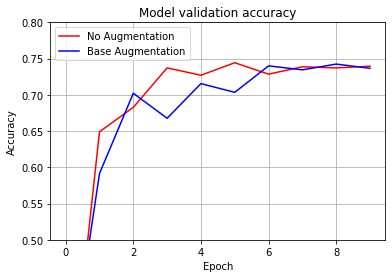

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    
plt.show()

###  Cutmix & Base Augmentation

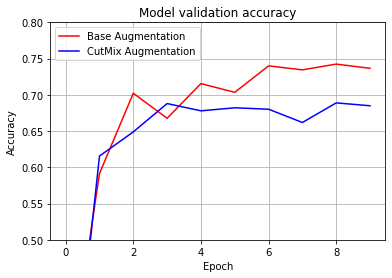

In [37]:
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    
plt.show()

### Mixup & Base Augmentation

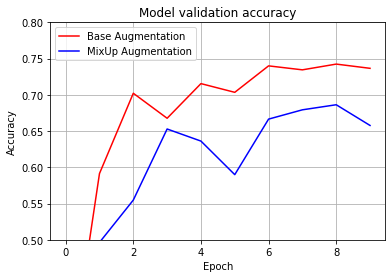

In [38]:
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    
plt.show()

### No & Base & Cutmix & Mixup Augmentation

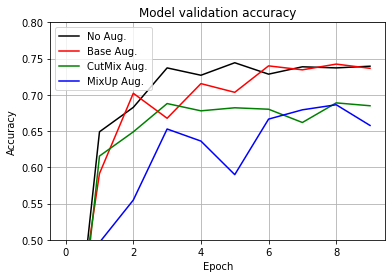

In [39]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Base Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    
plt.show()

이번 프로젝트를 하면서 화병 나서 죽을뻔 했습니다....  
no augmentation 학습 후, base augmentation 학습이 다 돌아가고,  
cutmix augmentation학습만 들어가면 커널이 계속 죽었습니다.  
처음에는 코드가 문제가 있거니 하고 계속 고치다 고치다 커널 죽은 것만 10번이 넘습니다.....  
그 커널이 돌아가기 까지 기다린 시간만 3,4시간씩 되구요...  
그래서 메모리가 문제인건가 해서 cutmix augmentation만 돌려보기도 했습니다.  
하지만 그래도 커널이 죽었습니다. 그러면 결국에 메모리 문제는 아닌 건가 싶었습니다.  
배치 사이즈를 조절해보기도 하고 epoch을 정말 낮게 3으로 돌려보기도 했습니다.  
그럼에도 cutmix에서 계속 커널이 죽었습니다...  
cutmix 데이터셋이 제 컴퓨터와 맞지 않은건지 에러가 나는것도 아니고, 그래서 도저히 못하겠어서 포기하려고 하다가, 누나가 오랜만에 집에 와서 맥북노트북이어서, 한번 돌려봤는데, 문제없이 cutmix까지 다 돌아가더군요....  근데 epoch을 10으로 해서 기대한 결과가 높지 않았지만,더 높게 돌리면 커널이 죽을까봐 무서워서 더 돌릴 엄두가 나질 않았습니다... 이유가 뭘까요.... 똑같은 코드를 그대로 다른 pc에서 실행했는데 문제가 없었다는건 코드가 문제가 아니라고밖에 생각이 되질 않는데..... 제 pc와 뭐가 맞질 않았던 걸까요.... resnet이 문제인거 같기도 하고..... resnet만 보면 제 pc가 힘이 빠지나 봅니다...